In [11]:
import sys
sys.path.append('..')

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import time
import shutil

root = 'D:/SchoolWork/Homework/XJTU/Research/LiveDemo/'

# Phase 1: Camera Test

In [12]:
from livecore.camera_utils import CameraManager
from tools.camera_visualizer import CameraVisualizer

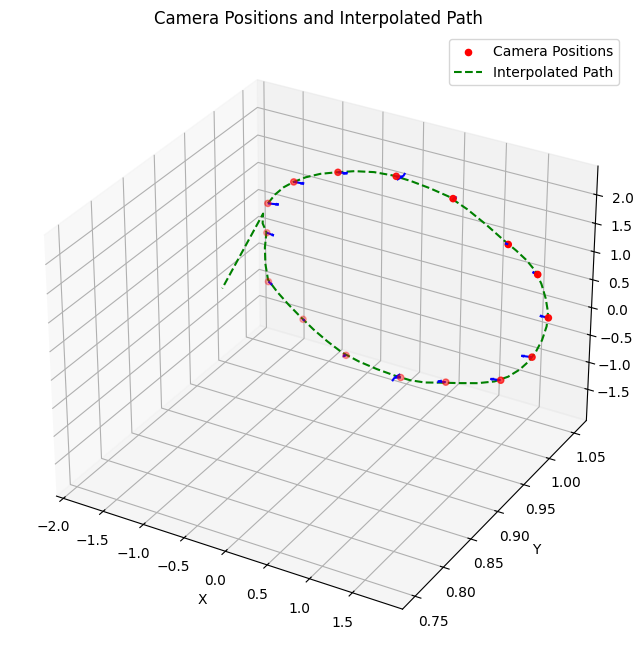

In [13]:
# 可视化相机的环形分布
camera_dir = os.path.join(root, 'configs/camera_params')
camera_manager = CameraManager(camera_dir)
visualizer = CameraVisualizer(camera_manager)
visualizer.visualize()

# Phase 2: Stream Matting Test

In [14]:
from livecore.matting_engine import MattingWrapper

In [15]:
matting_model_dir = os.path.join(root, 'models/rvm_mobilenetv3.pth')
mw = MattingWrapper(matting_model_dir)

In [16]:
from IPython.display import clear_output

# 执行单个文件的matting测试
test_video = os.path.join(root, 'data/input_videos/0.mp4')
cache_dir = os.path.join(root, 'data/cache')

# mw的方法是mw.process_frame，输入是一个BGR图像，输出是一个matting后的图像
# 以下测试内容为，读取视频，对每一帧进行matting，然后循环播放matting后的结果，单帧的渲染结果如果存在于cache_dir中，覆盖之，否则新建一个，显示

cap = cv2.VideoCapture(test_video)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(fps, frame_count, frame_width, frame_height)

if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

def test_matting():
    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_idx += 1
        if frame_idx % 2 == 0:
            continue
        matting_frame = mw.process_frame(frame)

        img_frame = (matting_frame * 255).astype(np.uint8)

        cv2.imwrite(os.path.join(cache_dir, 'matting_frame.jpg'), img_frame)

        clear_output()
        
        # 使用 matplotlib 显示图像
        plt.imshow(matting_frame, cmap='gray')
        plt.title('Matting Frame')
        plt.axis('off')
        plt.show()
        
        time.sleep(1/fps + 0.1)

        # plt.clf()

# test_matting()

cap.release()

30.0 450 1024 1024


# Phase 3: GPS-Gaussian Test

In [17]:
# 创建一个函数，用于检测一些路径（至少一个）是否存在，如果不存在则创建，如果存在则清空
def check_dir(path_list, clear=True):
    for path in path_list:
        if clear:
            if os.path.exists(path):
                shutil.rmtree(path)
            os.makedirs(path)
        else:
            if not os.path.exists(path):
                os.makedirs(path)

In [18]:
gps_model_dir = os.path.join(root, 'models/GPS-GS_stage2_final.pth')

test_data_dir = os.path.join(root, 'data/cache/real_data')

img_path = os.path.join(test_data_dir, 'img')
mask_path = os.path.join(test_data_dir, 'mask')
parm_path = os.path.join(test_data_dir, 'parm')

check_dir([test_data_dir, img_path, mask_path, parm_path])

In [19]:
'''
读取data/input_videos下的每一个视频，取其第一帧。视频名为{video_name}.mp4
1. 把所有的第一帧图片放到img_path/0001/下，命名为{video_name}.jpg
2. 对每一个图片进行matting，把matting后的结果放到mask_path/0001/下，命名为{video_name}.png
3. 拷贝configs/camera_params下的所有相机参数文件到parm_path/0001/下
'''

for i in range(16):
    video_path = os.path.join(root, 'data/input_videos', f'{i}.mp4')
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # 读取第一帧
    ret, frame = cap.read()
    if not ret:
        break

    # 保存第一帧
    img_save_path = os.path.join(img_path, '0', f'{i}.jpg')
    check_dir([os.path.join(img_path, '0')], clear=False)
    cv2.imwrite(img_save_path, frame)

    # matting
    matting_frame = mw.process_frame(frame)
    mask_save_path = os.path.join(mask_path, '0', f'{i}.png')
    check_dir([os.path.join(mask_path, '0')], clear=False)
    # cv2.imwrite(mask_save_path, (matting_frame * 255).astype(np.uint8))
    # 保存为 24 位 png
    if len(matting_frame.shape) == 2 or matting_frame.shape[2] == 1:
        matting_frame = cv2.cvtColor(matting_frame, cv2.COLOR_GRAY2RGB)

    # 保存为 RGB24 格式的 PNG 图像
    cv2.imwrite(mask_save_path, (matting_frame * 255).astype(np.uint8), [cv2.IMWRITE_PNG_COMPRESSION, 9])

    cap.release()

# 拷贝相机参数，直接将camera_params下的文件拷贝到parm_path/0/下
camera_params_dir = os.path.join(root, 'configs/camera_params')
parm_save_path = os.path.join(parm_path, '0')

if os.path.exists(parm_save_path):
    shutil.rmtree(parm_save_path)
shutil.copytree(camera_params_dir, parm_save_path)

'D:/SchoolWork/Homework/XJTU/Research/LiveDemo/data/cache/real_data\\parm\\0'

In [20]:
from livecore.gps_renderer import setup_renderer

# 设置参数
cfg_path = os.path.join(root, 'configs/gaussian_config')
output_path = os.path.join(root, 'data/cache/output')
src_view = [0, 1]  # 示例视角 ID
ratio = 0.5

check_dir([output_path])

# 初始化渲染器
renderer = setup_renderer(test_data_dir, gps_model_dir, output_path, cfg_path, src_view, ratio)

# 渲染单帧
renderer.infer_frame(view_select=src_view, ratio=ratio)

2025-02-21 01:08:28,368 INFO     [gps_renderer.py:89] Loading checkpoint from D:/SchoolWork/Homework/XJTU/Research/LiveDemo/models/GPS-GS_stage2_final.pth ...
2025-02-21 01:08:28,677 INFO     [gps_renderer.py:92] Parameter loading done
100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


# Phase 4: Ply Render Test

In [21]:
# python local_viewer.py --point_path "D:\SchoolWork\Homework\XJTU\Research\LiveDemo\data\cache\output\novel.ply"